# SVM на основе тензорного CP разложения

In [53]:
import numpy as np
import time
import tensorly as tl
import functools
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [77]:
class CP_LinearSVM:
    def __init__(self, CP_rank):
        self.cp_rank = CP_rank

               
    def createFactors(self, tensor):
        n_dim = tensor.ndim
        dictionary = {}
        
        for i in range(1, n_dim):
            array = np.random.randn(tensor.shape[i], self.cp_rank)
            dictionary[i] = array
            
        return dictionary
    
    
    def tensorUnfold(self, tensor, mode):
        n_dim = tensor.ndim
        indices = np.arange(n_dim).tolist()
        element = indices.pop(mode)
        sample_index = indices.pop(0)
        new_indices = ([sample_index] + [element] + indices)    
        
        samples = tensor.shape[0]
        return np.transpose(tensor, new_indices).reshape(samples, tensor.shape[mode], -1)
        
 
    def getsvmFunctions(self, tensor):
        n_dim = tensor.ndim
        
        optimize_functions = []
        
        for i in range(1, n_dim):
            def optimizer(opt_mat, dictionary, CP_rank, C, X, Y, i=i):
                samples = X.shape[0]
     
                vec_matrix = np.reshape(opt_mat, (CP_rank*X.shape[i], 1))
                matricize_X = self.tensorUnfold(tensor=X, mode=i)
                
                temp_dict = dict(dictionary)
                del temp_dict[i]
    
                new_matrices = list(temp_dict.values())
                new_matrices = new_matrices[::-1]
    
                khatri_product = tl.tenalg.khatri_rao(new_matrices)
                X_khatri = tl.tenalg.mode_dot(matricize_X, khatri_product.T, 2)
                vec_X_khatri = np.reshape(X_khatri, (samples, CP_rank*X.shape[i]))
                Y_hat = vec_X_khatri @ vec_matrix
    
                error = (1/samples)*np.sum(np.maximum(0, (1-Y.squeeze()*Y_hat.squeeze()))) + 0.5*C*np.linalg.norm(vec_matrix)**2
    
                return error
        
            optimize_functions.append(optimizer)
            
        return optimize_functions
        

    def fit(self, tensor, labels, C=1, max_iterations=200, sensitivity=1e-6, print_iterations=True):
        iterations = 0
        error = 1
        current_error = 0
        n_dim = tensor.ndim        
        
        init_dict = self.createFactors(tensor=tensor)
        optimize_functions = self.getsvmFunctions(tensor=tensor)
        
        while (error > sensitivity) and (iterations < max_iterations):
            prev_error = current_error
            
            for i in range(1, n_dim):
                initial_guess = init_dict[i]
                solve = functools.partial(optimize_functions[i-1], dictionary=init_dict, 
                                          CP_rank=self.cp_rank, C=C, X=tensor, Y=labels)
                solver = minimize(solve, initial_guess, method='SLSQP', tol=0.0001)
                initial_guess = np.reshape(solver.x, (initial_guess.shape))
                init_dict[i] = initial_guess
                
            current_error = solver.fun
            error = abs(prev_error - current_error)
            iterations += 1
            
            if print_iterations:
                print('Current Iteration: ' + str(iterations))
                print('Current Difference in Error Value: '+ str(error) + str('\n'))
                
        return init_dict    
        
    
    def reconstructTensor(self, solved_dict, tensor_n_dim):
        if tensor_n_dim == 2:
            A = solved_dict[1]
            B = solved_dict[2]
            
            recon_beta = np.zeros((A.shape[0], B.shape[0]))
            
            for i in range(tensor_n_dim):
                solved_prod = np.prod(np.ix_(A[:, i], B[:, i]))
                recon_beta += solved_prod
                
            return recon_beta
                
        elif tensor_n_dim == 3:
            A = solved_dict[1]
            B = solved_dict[2]
            C = solved_dict[3]
            
            recon_beta = np.zeros((A.shape[0], B.shape[0], C.shape[0]))
            
            for i in range(tensor_n_dim):
                solved_prod = np.prod(np.ix_(A[:, i], B[:, i], C[:, i]))
                recon_beta += solved_prod
                
            return recon_beta       

In [6]:
# Обычный SVM

def svmSolver(beta, C, vec_X, Y):
    samples = vec_X.shape[0]
    Y_hat = vec_X @ beta 
    error = (1/samples)*np.sum(np.maximum(0, (1-Y.squeeze()*Y_hat.squeeze()))) + 0.5*C*np.linalg.norm(beta)**2
    
    return error
    
    
def svmfit(vec_X, Y, C=1):
    init_beta = np.random.randn(vec_X.shape[1], 1)
    partial_solver = functools.partial(svmSolver, C=C, vec_X=vec_X, Y=Y)
    solved = minimize(partial_solver, init_beta, method='SLSQP')
    opt_weights = solved.x
    
    return opt_weights 

In [7]:
def evaluateMetrics(recon_tensor, true_tensor):
    recon_tensor = recon_tensor / np.linalg.norm(recon_tensor, 'fro')
    
    mse_val = np.linalg.norm(recon_tensor-true_tensor)**2
    
    vec_recon = np.reshape(recon_tensor, (-1, 1))
    vec_true = np.reshape(true_tensor, (-1, 1))
        
    recon_norm = np.linalg.norm(vec_recon)
    true_norm = np.linalg.norm(vec_true)
    
    cos_dis = (vec_true.T @ vec_recon) / (true_norm*recon_norm)
        
    num = np.linalg.norm((true_tensor-recon_tensor), 'fro')
    den = np.linalg.norm(true_tensor, 'fro')
        
    recon_err = num / den
    
    return mse_val, cos_dis, recon_err

## На сгенерированных данных

In [10]:
def generate_data(sample_size, noise_variance):
    A = np.array([[1]*15, [0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0]]).T
    B = np.array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0], [1]*15]).T
    x_shape = A.shape[0]
    y_shape = B.shape[0]
    
    X_train = np.random.randn(sample_size, x_shape, y_shape) 
    X_train_vec = np.reshape(X_train, (sample_size, x_shape*y_shape))
    
    cross_beta = A @ B.T
    vec_cross_beta = np.reshape(cross_beta, (x_shape*y_shape, 1))
    cross_norm = np.linalg.norm(cross_beta, 'fro')
    cross_beta = cross_beta / cross_norm
    Y_soft = np.zeros((sample_size, 1))
    
    for i in range(sample_size):
        epsilon = noise_variance * np.random.randn(1, 1)
        x_i = X_train_vec[i, :]
        y_i = (x_i @ vec_cross_beta) + epsilon
        Y_soft[i, :] = y_i
        
    Y_hard = np.sign(Y_soft)
    
    return cross_beta, X_train, Y_hard, Y_soft 

In [23]:
sample_size = 1500
variance = 1 #1.5
CP_rank = 2

true_pred, X, Y_hard, Y_soft = generate_data(sample_size, variance)

CP_SVM = CP_LinearSVM(CP_rank=CP_rank) 
start = time.time()
svm_dict = CP_SVM.fit(X, Y_hard, print_iterations=False) 
cp_svm_reconstructed = CP_SVM.reconstructTensor(solved_dict=svm_dict, tensor_n_dim=2) 
print(f"time consumed CP-SVM {time.time() - start} s")

params = 0
for i in svm_dict:
    params += svm_dict[i].size
print('CP svm params = ', params)

# print(np.dot(cp_svm_reconstructed.reshape((1,15,15)), X).shape)
# print(np.inner(cp_svm_reconstructed, X).shape)
# y_pred = []
# for i in
start = time.time()
y_pred = np.inner(cp_svm_reconstructed.reshape(-1), np.reshape(X, (sample_size, X.shape[1]*X.shape[2])))
y_pred_sign = np.sign(y_pred)

print('CP-SVM acc', accuracy_score(Y_hard.reshape(-1), y_pred_sign))
print(f"time infer CP-SVM {time.time() - start} s")



# training traditional SVM model
# vec_SVM = traditionalML(algorithm='Linear SVM') # instantiating class
vec_X = np.reshape(X, (sample_size, -1)) # vectorizing data
start = time.time()
vec_svm_params = svmfit(vec_X, Y_hard)
print(f"time consumed SVM {time.time() - start} s")
vec_svm_reconstructed = np.reshape(vec_svm_params, (cp_svm_reconstructed.shape))

start = time.time()
y_pred2 = np.sign(np.inner(vec_svm_params, np.reshape(X, (sample_size, X.shape[1]*X.shape[2]))))
print('SVM acc', accuracy_score(Y_hard.reshape(-1), y_pred2))
print(f"time infer SVM {time.time() - start} s")



print('Traditional svm params = ', vec_svm_params.shape)

d:\Python\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


time consumed CP-SVM 4.105848789215088 s
CP svm params =  60
CP-SVM acc 0.8766666666666667
time infer CP-SVM 0.003003358840942383 s
time consumed SVM 4.182396650314331 s
SVM acc 0.9266666666666666
time infer SVM 0.0009992122650146484 s
Traditional svm params =  (225,)


CP MSE: 0.15359745753730597
Traditional MSE: 0.18303336006493165 

CP Cosine Distance: [[0.92320127]]
Traditional Cosine Distance: [[0.90848332]] 

CP Reconstruction Error: 0.39191511521923467
Traditional Reconstruction Error: 0.4278239825733612 



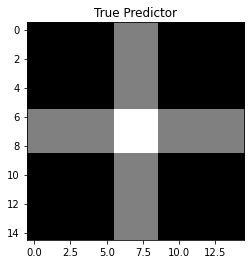

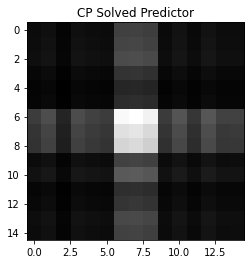

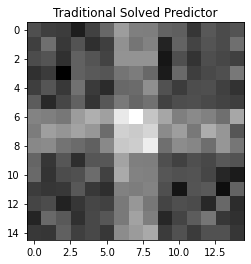

In [17]:
cp_mse_val, cp_cos_dis, cp_recon_err = evaluateMetrics(cp_svm_reconstructed, true_pred) 
vec_mse_val, vec_cos_dis, vec_recon_err = evaluateMetrics(vec_svm_reconstructed, true_pred)

print('CP MSE:', cp_mse_val)
print('Traditional MSE:', vec_mse_val, '\n')

print('CP Cosine Distance:', cp_cos_dis)
print('Traditional Cosine Distance:', vec_cos_dis, '\n')

print('CP Reconstruction Error:', cp_recon_err)
print('Traditional Reconstruction Error:', vec_recon_err, '\n')


plt.imshow(true_pred, cmap='gray')
plt.title('True Predictor')
plt.show()

plt.imshow(cp_svm_reconstructed, cmap='gray')
plt.title('CP Solved Predictor')
plt.show()

plt.imshow(vec_svm_reconstructed, cmap='gray')
plt.title('Traditional Solved Predictor')
plt.show()

## MNIST

In [29]:
from scipy.io import loadmat

In [52]:
def normalize(data):
    mean = np.mean(data, axis=1, keepdims=True)
    std = np.std(data, axis=1, keepdims=True)
    data_normalized = (data - mean)/std
    return data_normalized

In [36]:
mnist = loadmat("./mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

# Используем только 750 цифр, повторяя за статьей
# num_samples = 750

# random_indices = np.random.choice(mnist_data.shape[0], num_samples, replace=False)

# mnist_data = mnist_data[random_indices, :]
# mnist_label = mnist_label[random_indices]

In [40]:
mnist_data.shape, mnist_label.shape

((70000, 784), (70000,))

In [37]:
mnist_label[mnist_label == 1].shape, mnist_label[mnist_label != 1].shape

((7877,), (62123,))

In [51]:
idx_not1 = np.where(mnist_label != 1)[0]
idx_1 = np.where(mnist_label == 1)[0]
random_indices = np.random.choice(mnist_data[idx_not1].shape[0], mnist_data[idx_1].shape[0], replace=False)

mnist_data = mnist_data[np.r_[random_indices, idx_1], :]
mnist_label = mnist_label[np.r_[random_indices, idx_1]]

In [54]:
# Предобработка данных
#Нормализуем данные
mnist_data_normalized = normalize(mnist_data)
#Приводим к тензорному виду 28 * 28
mnist_data_tensor_normalized = mnist_data_normalized.reshape(mnist_data.shape[0], 28,28) 

X_train, X_test, Y_train, Y_test = train_test_split(mnist_data_normalized, mnist_label, test_size=0.20, random_state=42)
Y_train = Y_train.reshape(Y_train.shape[0],1)
Y_test = Y_test.reshape(Y_test.shape[0],1)

print("The shape of the training set feature matrix is:", X_train.shape)
print("The shape of the training label vector is:", Y_train.shape)
print("The shape of the test set feature matrix is:", X_test.shape)
print("The shape of the test label vector is:", Y_test.shape)

Y_train_1=(Y_train==1).astype(int)
Y_test_1=(Y_test==1).astype(int)

Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(mnist_data_tensor_normalized, mnist_label, test_size=0.20, random_state=42)

print("The shape of the training set feature matrix is:", Xt_train.shape)
print("The shape of the training label vector is:", Yt_train.shape)
print("The shape of the test set feature matrix is:", Xt_test.shape)
print("The shape of the test label vector is:", Yt_test.shape)

Yt_train.reshape(Yt_train.shape[0],1)
Yt_train=(Yt_train==1).astype(int)
Yt_train_1=Yt_train * 2 - 1 #Делаем метки для 1 и не единицы равными 1 и -1

# Creating new testing label vectors for each digit for the one-vs-all methode
Yt_test.reshape(Yt_test.shape[0],1)
Yt_test=(Yt_test==1).astype(int)
Yt_test_1=Yt_test * 2 -1

The shape of the training set feature matrix is: (12603, 784)
The shape of the training label vector is: (12603, 1)
The shape of the test set feature matrix is: (3151, 784)
The shape of the test label vector is: (3151, 1)
The shape of the training set feature matrix is: (12603, 28, 28)
The shape of the training label vector is: (12603,)
The shape of the test set feature matrix is: (3151, 28, 28)
The shape of the test label vector is: (3151,)


In [60]:
CP_rank = 2

# training CP SVM model
CP_SVM = CP_LinearSVM(CP_rank=CP_rank) # instantiating class
start = time.time()
svm_dict = CP_SVM.fit(Xt_train[:], Yt_train_1[:]) # fitting data (X, y)
cp_svm_reconstructed = CP_SVM.reconstructTensor(solved_dict=svm_dict, tensor_n_dim=2) # reconstruct tensor
print(f"time consumed CP-SVM {time.time() - start} s")

params = 0
for i in svm_dict:
    params += svm_dict[i].size
print('CP svm params = ', params)


start = time.time()
y_pred = np.inner(cp_svm_reconstructed.reshape(-1), np.reshape(Xt_test, (Xt_test.shape[0], Xt_test.shape[1]*Xt_test.shape[2])))
y_pred_sign = np.sign(y_pred)

print(f"time infer CP-SVM {time.time() - start} s")
print('CP-SVM acc', accuracy_score(Yt_test_1.reshape(-1), y_pred_sign))

Current Iteration: 1
Current Difference in Error Value: 0.8634118314356274

Current Iteration: 2
Current Difference in Error Value: 0.42223021472604744

Current Iteration: 3
Current Difference in Error Value: 0.08216903695750494

Current Iteration: 4
Current Difference in Error Value: 0.05971469075101843

Current Iteration: 5
Current Difference in Error Value: 0.026802482216580215

Current Iteration: 6
Current Difference in Error Value: 0.006802178122770175

Current Iteration: 7
Current Difference in Error Value: 0.001121702062866381

Current Iteration: 8
Current Difference in Error Value: 0.0005286300430085156

Current Iteration: 9
Current Difference in Error Value: 0.0002607366402140876

Current Iteration: 10
Current Difference in Error Value: 0.00024399251364842778

Current Iteration: 11
Current Difference in Error Value: 0.0

time consumed CP-SVM 186.59584212303162 s
CP svm params =  112
time infer CP-SVM 0.0 s
CP-SVM acc 0.9584258965407807


d:\Python\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [63]:
CP_rank = 3

# training CP SVM model
CP_SVM = CP_LinearSVM(CP_rank=CP_rank) # instantiating class
start = time.time()
svm_dict = CP_SVM.fit(Xt_train[:], Yt_train_1[:]) # fitting data (X, y)
cp_svm_reconstructed = CP_SVM.reconstructTensor(solved_dict=svm_dict, tensor_n_dim=2) # reconstruct tensor
print(f"time consumed CP-SVM {time.time() - start} s")

params = 0
for i in svm_dict:
    params += svm_dict[i].size
print('CP svm params = ', params)


start = time.time()
y_pred = np.inner(cp_svm_reconstructed.reshape(-1), np.reshape(Xt_test, (Xt_test.shape[0], Xt_test.shape[1]*Xt_test.shape[2])))
y_pred_sign = np.sign(y_pred)

print(f"time infer CP-SVM {time.time() - start} s")
print('CP-SVM acc', accuracy_score(Yt_test_1.reshape(-1), y_pred_sign))

Current Iteration: 1
Current Difference in Error Value: 0.5329696914522862

Current Iteration: 2
Current Difference in Error Value: 0.21563722576709643

Current Iteration: 3
Current Difference in Error Value: 0.039827396200841636

Current Iteration: 4
Current Difference in Error Value: 0.012460240240187659

Current Iteration: 5
Current Difference in Error Value: 0.003213373677920295

Current Iteration: 6
Current Difference in Error Value: 0.0002492750814054312

Current Iteration: 7
Current Difference in Error Value: 0.003999622475955755

Current Iteration: 8
Current Difference in Error Value: 0.00026390496175704437

Current Iteration: 9
Current Difference in Error Value: 0.00011208277687191348

Current Iteration: 10
Current Difference in Error Value: 0.00024525452327645025

Current Iteration: 11
Current Difference in Error Value: 6.745220258175255e-06

Current Iteration: 12
Current Difference in Error Value: 3.843942806724954e-06

Current Iteration: 13
Current Difference in Error Value

d:\Python\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [62]:
vec_X = np.reshape(Xt_train, (Xt_train.shape[0], -1)) # vectorizing data
start = time.time()
vec_svm_params = svmfit(vec_X, Yt_train_1)
print(f"time consumed SVM {time.time() - start} s")
vec_svm_reconstructed = np.reshape(vec_svm_params, (cp_svm_reconstructed.shape))

start = time.time()
y_pred2 = np.sign(np.inner(vec_svm_params, np.reshape(Xt_test, (Xt_test.shape[0], Xt_test.shape[1]*Xt_test.shape[2]))))
print('SVM acc', accuracy_score(Yt_test_1.reshape(-1), y_pred2))
print(f"time infer SVM {time.time() - start} s")



print('Traditional svm params = ', vec_svm_params.shape)

time consumed SVM 104.97408032417297 s
SVM acc 0.9822278641701048
time infer SVM 0.0 s
Traditional svm params =  (784,)


In [61]:
# model_1 = LogRegModel(X_train[:], X_test[:], Y_train_1[:], Y_test_1[:], alpha=0.01, max_iter=1000)


# vec_X = np.reshape(X, (sample_size, -1)) # vectorizing data
start = time.time()
vec_svm_params = svmfit(X_train, Y_train_1)
print(f"time consumed SVM {time.time() - start} s")
vec_svm_reconstructed = np.reshape(vec_svm_params, (cp_svm_reconstructed.shape))


start = time.time()
y_pred2 = np.sign(np.inner(vec_svm_params, X_test))

print(f"time infer SVM {time.time() - start} s")
print('SVM acc', accuracy_score(Y_test_1, y_pred2))

print('Traditional svm params = ', vec_svm_params.shape)

time consumed SVM 88.37055253982544 s
time infer SVM 0.0009982585906982422 s
SVM acc 0.5725166613773405
Traditional svm params =  (784,)


## 3D MNIST

In [83]:
import h5py
hf_train = h5py.File("./train_point_clouds.h5", "r")  
hf_test = h5py.File("./test_point_clouds.h5", "r")  

In [84]:
def cube (dots):
    cub = np.zeros((16,16,16))
    ndots = dots.shape[0]
    for dot in dots:
        if dot[0] > 0.5:
            dot[0] = 0.5
        elif dot[0] < -0.5:
            dot[0] = -0.5
        if dot[1] > 0.5:
            dot[1] = 0.5
        elif dot[1] < -0.5:
            dot[1] = -0.5
        if dot[2] > 0.5:
            dot[2] = 0.5
        elif dot[2] < -0.5:
            dot[2] = -0.5
        dot[0] += 0.5
        dot[1] += 0.5
        dot[2] += 0.5
        n1 = round(dot[0]/0.0625)
        n2 = round(dot[1]/0.0625)
        n3 = round(dot[2]/0.0625)
        if n1 == 16:
            n1 = 15
        if n2 == 16:
            n2 = 15
        if n3 == 16:
            n3 = 15
        cub[n1][n2][n3] += 1/ndots
        #if cub[n1][n2][n3] != 0:
        #    print(cub[n1][n2][n3])
    return cub

In [85]:
hf_train_ones = []
for i in range(1000):
    if hf_train[str(i)].attrs['label'] == 1:
        hf_train_ones.append(i)

hf_test_ones = []
for i in range(1000):
    if hf_test[str(i)].attrs['label'] == 1:
        hf_test_ones.append(i)

In [86]:
X_3d_train = []
y_3d_train = []
X_d_train = []

dots = 500

for i in range(1000):
    #inds = np.sort(np.random.choice(hf_train[str(i)]['points'].shape[0], dots, replace=False))
    cub = cube(hf_train[str(i)]['points'][:, : ])
    #hf_train[str(i)]['points'][inds, : ]
    X_3d_train.append(cub)
    X_d_train.append(cub.reshape(-1))
    y_3d_train.append(hf_train[str(i)].attrs['label'])

In [87]:
X_3d_test = []
y_3d_test = []
X_d_test = []

for i in range(100):
    #inds = np.sort(np.random.choice(hf_test[str(i)]['points'].shape[0], dots, replace=False))
    cub = cube(hf_test[str(i)]['points'][:, : ])
    X_3d_test.append(cub)
    #X_d_test.append(np.array(hf_test[str(i)]['points'][inds,  : ]).reshape(-1))
    X_d_test.append(cub.reshape(-1))
    y_3d_test.append(hf_test[str(i)].attrs['label'])

In [88]:
y_3d_train= np.array(y_3d_train)
y_3d_train_1 = (y_3d_train==1).astype(int)*2-1
X_3d_train = np.array(X_3d_train)
X_d_train = np.array(X_d_train)

y_3d_test= np.array(y_3d_test)
y_3d_test_1 = (y_3d_test==1).astype(int)*2-1
X_3d_test = np.array(X_3d_test)
X_d_test = np.array(X_d_test)

In [89]:
CP_rank = 3

# training CP SVM model
CP_SVM = CP_LinearSVM(CP_rank=CP_rank)
start = time.time()
svm_dict = CP_SVM.fit(X_3d_train, y_3d_train_1)
cp_svm_reconstructed = CP_SVM.reconstructTensor(solved_dict=svm_dict, tensor_n_dim=3) 
print(f"3D time consumed CP-SVM {time.time() - start} s")

params = 0
for i in svm_dict:
    params += svm_dict[i].size
print('3D CP svm params = ', params)


start = time.time()
y_pred = np.inner(cp_svm_reconstructed.reshape(-1), np.reshape(X_3d_test, (X_3d_test.shape[0], X_3d_test.shape[1]*X_3d_test.shape[2]*X_3d_test.shape[3])))
y_pred_sign = np.sign(y_pred)

predict = []
for t in X_3d_test:
    predict.append(np.sign(np.sum(t * cp_svm_reconstructed)))
predict = np.array(predict)
print(accuracy_score(y_3d_test_1, predict))

print(f"time infer CP-SVM {time.time() - start} s")
print('CP-SVM acc', accuracy_score(y_3d_test_1, y_pred_sign))

Current Iteration: 1
Current Difference in Error Value: 1.0000000000005234

Current Iteration: 2
Current Difference in Error Value: 1.1102230246251565e-15

3D time consumed CP-SVM 8.588313102722168 s
3D CP svm params =  144
0.74
time infer CP-SVM 0.0 s
CP-SVM acc 0.74


d:\Python\lib\site-packages\numpy\core\fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [91]:
vec_X = np.reshape(X_3d_train, (X_3d_train.shape[0], -1)) 
start = time.time()
vec_svm_params = svmfit(vec_X, y_3d_train_1)
print(f"time consumed SVM {time.time() - start} s")
vec_svm_reconstructed = np.reshape(vec_svm_params, (cp_svm_reconstructed.shape))

start = time.time()
y_pred2 = np.sign(np.inner(vec_svm_params, np.reshape(X_3d_test, (X_3d_test.shape[0], X_3d_test.shape[1]*X_3d_test.shape[2]*X_3d_test.shape[3]))))
print('SVM acc', accuracy_score(y_3d_test_1, y_pred2))
print(f"time infer SVM {time.time() - start} s")



print('Traditional svm params = ', vec_svm_params.shape)

time consumed SVM 195.55845880508423 s
SVM acc 0.86
time infer SVM 0.0 s
Traditional svm params =  (4096,)


In [ ]:
CP_ = CP_LogisticRegression(CP_rank=3) 
start = time.time()
log_dict = CP_.fit(X_3d_train, y_3d_train_1, max_iterations=50, C = 0.0005)
end = time.time()

cp_reconstructed = CP_.reconstructTensor(solved_dict=log_dict, tensor_n_dim=3) 

print(f"time consumed {end - start} s")
predict = []
for t in X_3d_test:
    predict.append(expit(np.sum(t * cp_reconstructed)))
predict = np.array(predict)